**Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.**

Attribute Information:

The explanations of sensor measurements and their brief statistics are given below.

Variable (Abbr.) Unit Min Max Mean

Ambient temperature (AT) C â€“6.23 37.10 17.71

Ambient pressure (AP) mbar 985.85 1036.56 1013.07

Ambient humidity (AH) (%) 24.08 100.20 77.87

Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93

Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56

Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43

Turbine after temperature (TAT) C 511.04 550.61 546.16

Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06

Turbine energy yield (TEY) MWH 100.02 179.50 133.51

Carbon monoxide (CO) mg/m3 0.00 44.10 2.37

Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression 

In [2]:
from google.colab import files
uploaded=files.upload()

Saving gas_turbines.csv to gas_turbines.csv


In [3]:
#loading data
data = pd.read_csv('gas_turbines.csv')
data.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


**Descriptive Statistics**

In [4]:
data.isna().sum().sum()

0

In [5]:
data.duplicated().sum()

0

In [6]:
data.shape

(15039, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [9]:
data.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


In [10]:
data.corr()['TEY'].sort_values(ascending=False)

#very strong correlation of output TEY with input CDP, GTEP, TIT, AFDP

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

**Visualisation**

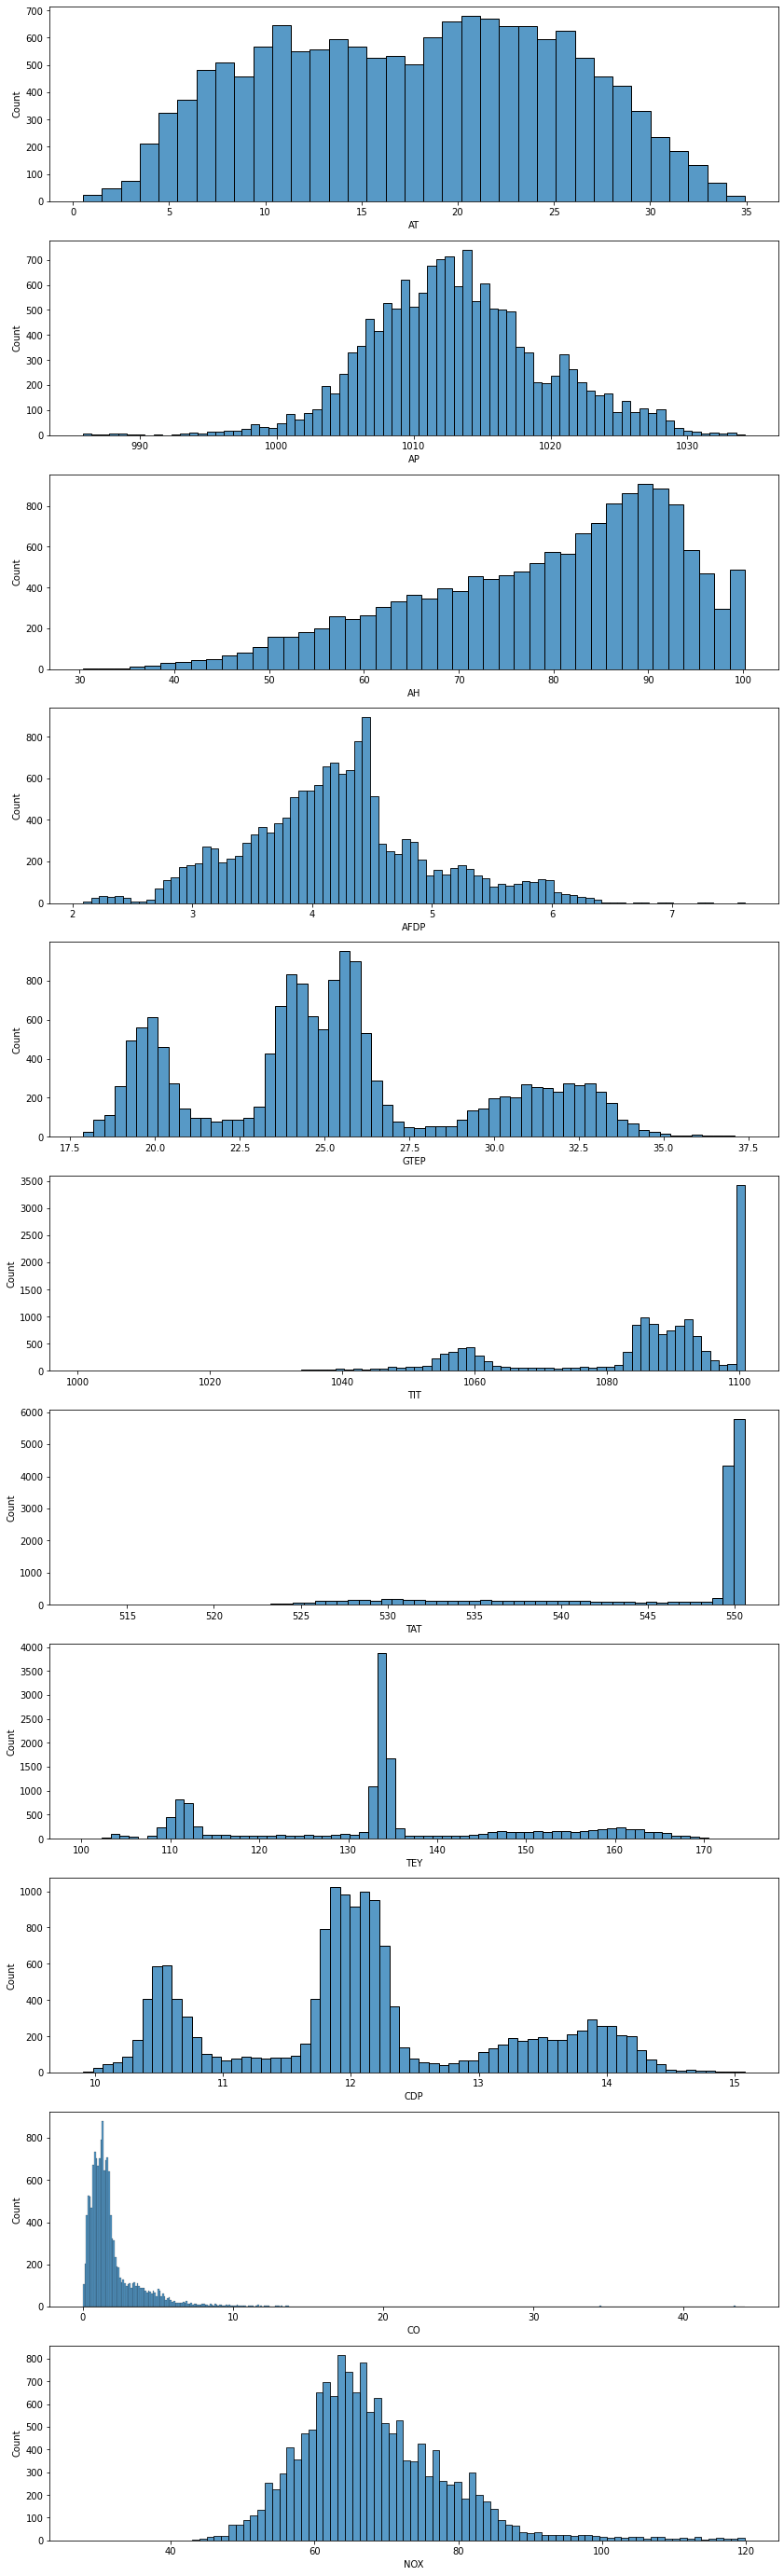

In [11]:
# for numerical_features -- histogram
fig, axes=plt.subplots(len(data.columns),1,figsize=(14,50))
i = 0 
for col in data.columns:
    sns.histplot(data[col],ax=axes[i])
    i = i+ 1

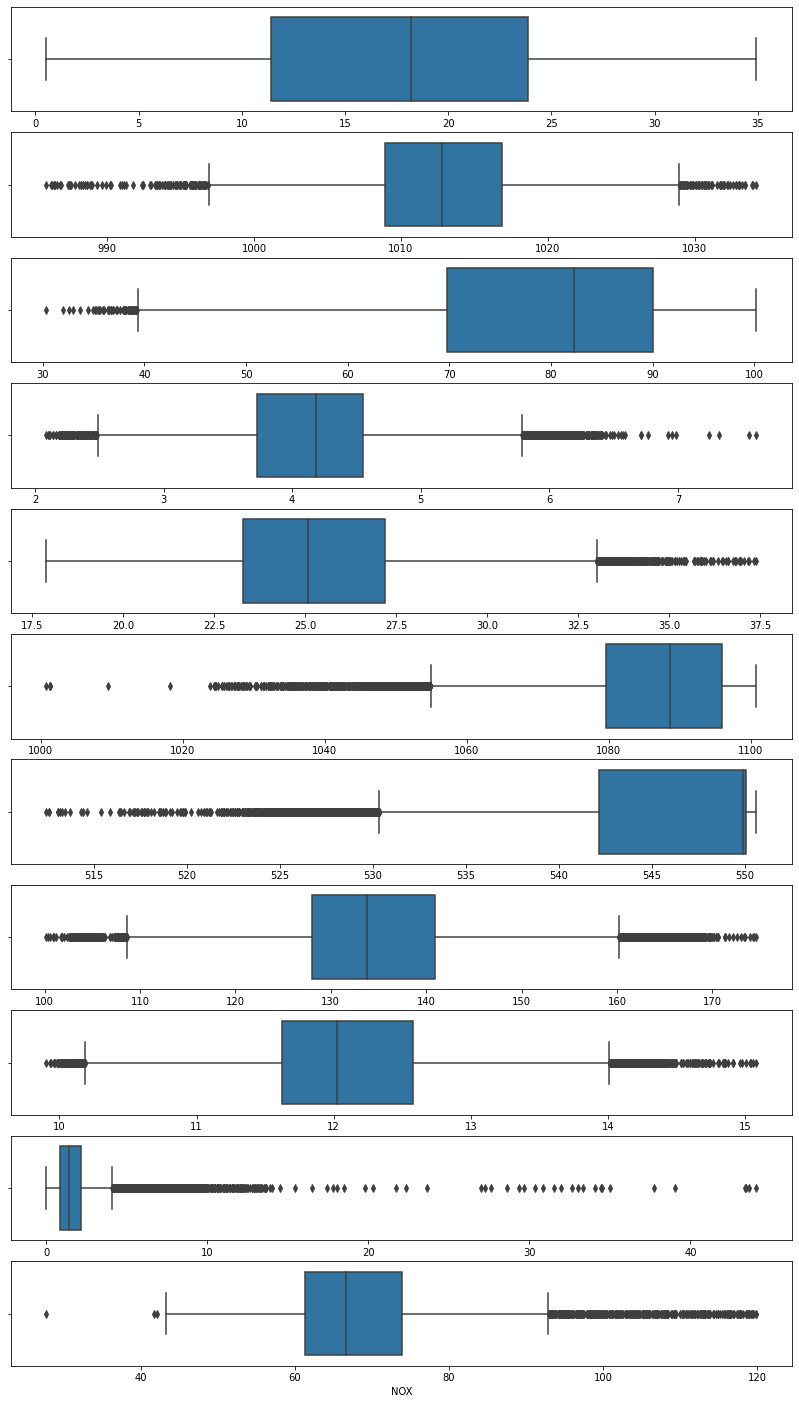

In [12]:
# outlier detection

fig, axes=plt.subplots(len(data.columns),1,figsize=(14,25))
i = 0 
for col in data.columns:
    sns.boxplot(data[col],ax=axes[i])
    i = i+ 1
      

**Univariate analysis**

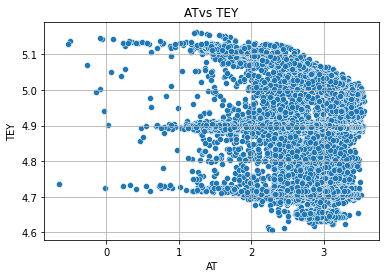

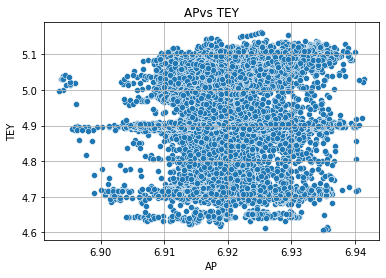

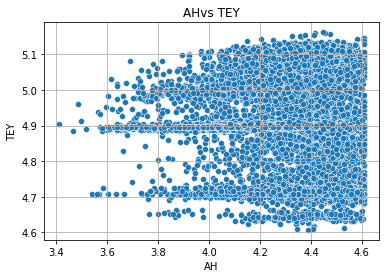

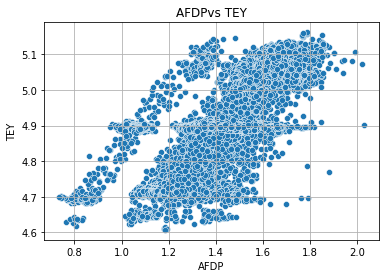

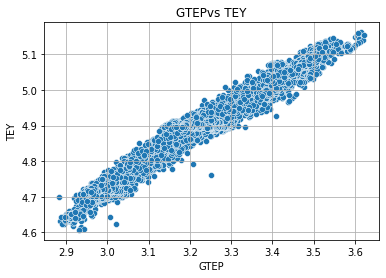

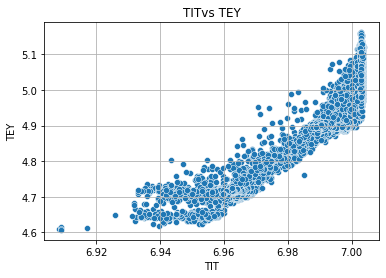

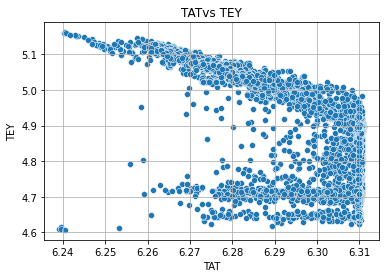

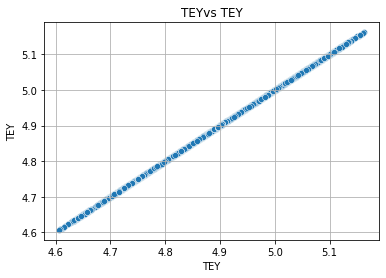

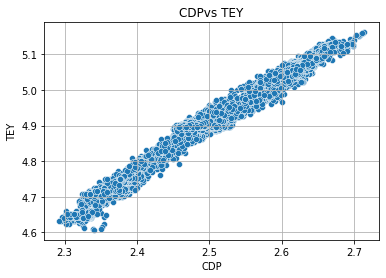

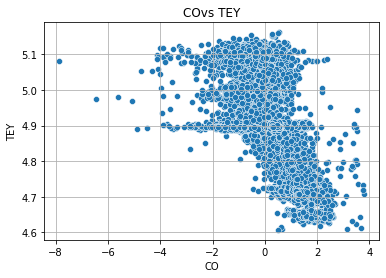

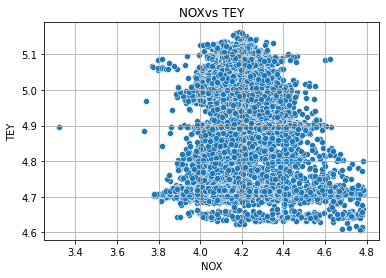

In [13]:
i = 0 
for col in data.columns:
    sns.scatterplot(np.log(data[col]), np.log(data['TEY']))
    plt.title(col+ 'vs TEY')
    i = i+ 1
    plt.grid()
    plt.show()
      

**Feature Selection**

In [14]:
x = data.drop('TEY', axis=1)
y = data[["TEY"]] 

In [15]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest


# feature extraction
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y) 


# summarize scores
scores = fit.scores_
features = fit.transform(x) 
score_df = pd.DataFrame()
score_df['Scores'] = scores
score_df['Features'] = x.columns

score_df.sort_values(by="Scores", ascending=False, inplace=True)
score_df  

,Scores,Features
7,1.713165,CDP
4,1.600417,GTEP
5,1.326024,TIT
6,0.893575,TAT
3,0.660787,AFDP
8,0.512632,CO
0,0.412792,AT
9,0.300934,NOX
1,0.137702,AP
2,0.097708,AH


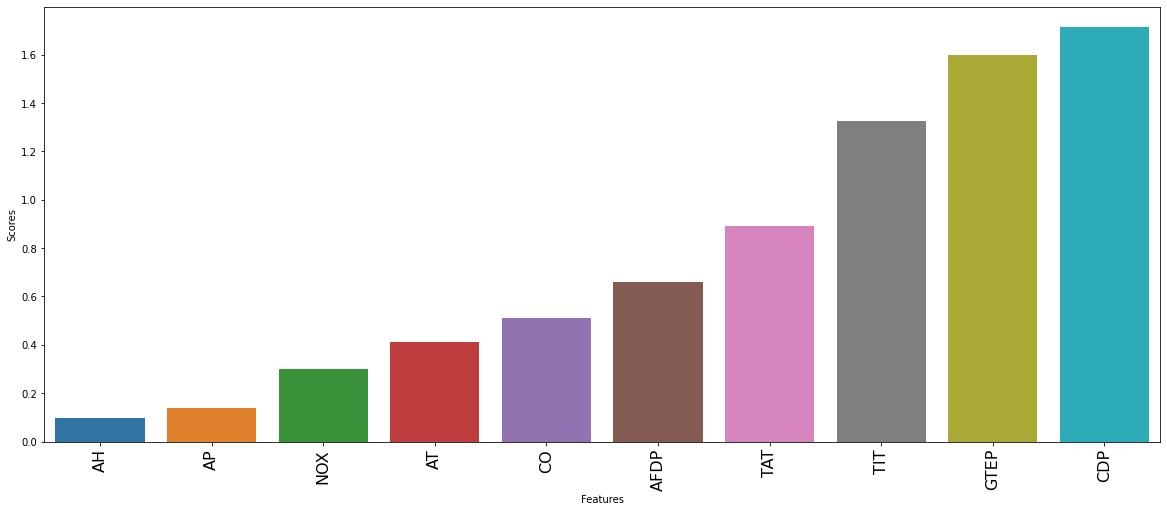

In [16]:
plt.figure(figsize=(20,8))
sns.barplot(x='Features', y="Scores", data=score_df, order=score_df.sort_values('Scores').Features) 
plt.xticks(rotation = 90, fontsize = 16)
plt.show() 

In [17]:
x = x[['CDP', 'GTEP', 'TIT', 'TAT', 'AFDP', 'CO', 'AT']]
x.head() 

,CDP,GTEP,TIT,TAT,AFDP,CO,AT
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978


In [18]:
# Applying Standard Scaler

#scaler = StandardScaler()

#x_std = scaler.fit_transform(x)
#y_std = scaler.fit_transform(y)

#x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.3, random_state=3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)   

Shape of X_train:  (10527, 7)
Shape of X_test:  (4512, 7)
Shape of y_train:  (10527, 1)
Shape of y_test (4512, 1)


**Building Model for ANN**

In [19]:
model = Sequential()
model.add(Dense(32,input_dim=7,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(96,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(96,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(96,activation="relu"))
model.add(Dense(1,activation="linear"))

In [20]:
adam=Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error',optimizer = adam,metrics=["mean_squared_error"])
model.fit(x_train, y_train, batch_size=20, validation_split=0.3, epochs = 100, verbose=-1)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [21]:
from sklearn.metrics import mean_squared_error as mse 

pred = model.predict(x_test)
error = np.sqrt(mse(y_test, pred))

print('RMSE of model is:' , error) 

141/141 [==============================] - 0s 2ms/step
RMSE of model is: 1.0399219728916678


In [22]:
y_actual = y_test
y_predicted = pred

df = pd.DataFrame()
df['Actual'] = y_actual
df['Predicted'] = np.round(pred,3) 

df 

,Actual,Predicted
8185,164.34,162.772995
8994,133.67,132.490997
8944,163.41,162.994003
3451,109.78,109.651001
8236,135.01,133.354996
...,...,...
4964,133.78,133.276993
9159,137.00,136.742004
12903,111.53,111.341003
6025,109.77,109.969002
